In [1]:
import pathlib
import os
import sys
from torch.utils.data import DataLoader
import torch
import torchvision
import random

PACKAGE_PARENT = pathlib.Path.cwd().parent 
SCR_DIR = os.path.join(PACKAGE_PARENT, 'src')
sys.path.append(SCR_DIR)

from config.loc_config import TRAIN_DATA_LOC, TEST_DATA_LOC, PRED_DATA_LOC, ANNOT_LOC, MODEL_SAVE_LOC, REPORT_SAVE_LOC
from config.data_config import INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL, BATCH_SIZE, NUM_WORKERS
from preprocessing.utils import build_annotation_dataframe, check_annot_dataframe, transform_bilinear
from model.dataset import IntelDataset, create_validation_dataset
import model.cnn_model as cnn_model
import model.modelling_config as modelling_config
import model.ensemble_model as ensemble_model
from postprocessing.utils import save_model_with_timestamp, save_csv_with_timestamp, calculate_model_performance, generate_fn_cost_matrix, generate_fp_cost_matrix

In [2]:
import importlib
import model.dataset
import model.cnn_model as cnn_model
import model.custom_loss_function as custom_loss_function
import config.loc_config
import postprocessing.utils
importlib.reload(model.dataset)
importlib.reload(model.cnn_model)
importlib.reload(model.modelling_config)
importlib.reload(model.ensemble_model)
importlib.reload(model.custom_loss_function)
importlib.reload(config.loc_config)
importlib.reload(postprocessing.utils)
from model.dataset import IntelDataset, create_validation_dataset
import model.cnn_model as cnn_model
import model.modelling_config as modelling_config
import model.ensemble_model as ensemble_model
import config.loc_config
from postprocessing.utils import save_model_with_timestamp, save_csv_with_timestamp

In [3]:
print(torch.backends.cudnn.enabled)
print(torch.cuda.is_available())

True
True


### 1. Creating and Preprocessing Input Dataset

In [4]:
train_df = build_annotation_dataframe(image_location=TRAIN_DATA_LOC, annot_location=ANNOT_LOC, output_csv_name='train.csv')
test_df = build_annotation_dataframe(image_location=TEST_DATA_LOC, annot_location=ANNOT_LOC, output_csv_name='test.csv')
class_names = list(train_df['class_name'].unique())
print(class_names)
print(check_annot_dataframe(train_df))
print(check_annot_dataframe(test_df))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[(4, 'sea'), (1, 'forest'), (3, 'mountain'), (5, 'street'), (2, 'glacier'), (0, 'buildings')]
[(4, 'sea'), (1, 'forest'), (3, 'mountain'), (5, 'street'), (2, 'glacier'), (0, 'buildings')]


Note for cell below: inception_v3 needs input shape of [batch_size, 3, 299, 299], hence we cannot use the original 224*224 image size. Here, we simply double the size. Detailed below:
https://discuss.pytorch.org/t/error-in-training-inception-v3/23933

In [5]:
image_transform = transform_bilinear(INPUT_WIDTH*2, INPUT_HEIGHT*2)
main_dataset = IntelDataset(annot_df = train_df, transform=image_transform)
train_dataset, validation_dataset = create_validation_dataset(main_dataset, validation_proportion=0.2)
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(validation_dataset))

test_dataset = IntelDataset(annot_df = test_df, transform=image_transform)
print('Test set size: ', len(test_dataset))

11227 2807
Train set size:  11227
Validation set size:  2807
Test set size:  3000


c:\Users\phuon\OneDrive\Documents\GitHub\intel_img_clf_pytorch\venv39cuda\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### 2. Configuring the Dataloaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

### 4. Set the device (CPU/GPU)

In [8]:
device = modelling_config.get_default_device()
device

device(type='cuda')

### 5. Loading the Pre-trained Models with Frozen Parameters and Exploring Them

In [9]:
# The Pytorch API calls a pre-trained model and move it to the default device
resnet = torchvision.models.resnet50(weights = True).to(device) 
inception = torchvision.models.inception_v3(weights = True).to(device)
# Telling the model to keep pre-trained weights
for param in resnet.parameters():    
    param.requires_grad = False
for param in inception.parameters():
    param.requires_grad = False

c:\Users\phuon\OneDrive\Documents\GitHub\intel_img_clf_pytorch\venv39cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\phuon\OneDrive\Documents\GitHub\intel_img_clf_pytorch\venv39cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# We can use .named_children() method to check the layers (children) of resnet
# adapted from: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b
print('resnet architecture: ')
children_counter = 0
for n, c in resnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter += 1
print('-'*20)
print('inception_v3 architecture: ')
children_counter = 0
for n,c in resnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

resnet architecture: 
Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc
--------------------
inception_v3 architecture: 
Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [11]:
# Examining the final fc layers of these models:
print(resnet.fc)
print(inception.fc)
print(resnet.fc.in_features)
print(inception.fc.in_features)

Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=1000, bias=True)
2048
2048


### 6. Training and Exporting the Ensemble CNN Model

#### 6.1. With 8 Epochs

Epoch 1 	 Training Loss: 0.581 	 Validation Loss: 0.56 	 Epoch Train Accuracy (%): 79.4 	 Epoch Time (s): 282.4
Epoch 2 	 Training Loss: 0.353 	 Validation Loss: 0.453 	 Epoch Train Accuracy (%): 87.04 	 Epoch Time (s): 255.1
Epoch 3 	 Training Loss: 0.338 	 Validation Loss: 0.588 	 Epoch Train Accuracy (%): 87.42 	 Epoch Time (s): 266.6
Epoch 4 	 Training Loss: 0.308 	 Validation Loss: 0.446 	 Epoch Train Accuracy (%): 88.62 	 Epoch Time (s): 267.9
Epoch 5 	 Training Loss: 0.306 	 Validation Loss: 0.431 	 Epoch Train Accuracy (%): 88.86 	 Epoch Time (s): 275.9
Epoch 6 	 Training Loss: 0.305 	 Validation Loss: 0.483 	 Epoch Train Accuracy (%): 88.77 	 Epoch Time (s): 271.5
Epoch 7 	 Training Loss: 0.305 	 Validation Loss: 0.439 	 Epoch Train Accuracy (%): 88.39 	 Epoch Time (s): 264.1
Epoch 8 	 Training Loss: 0.295 	 Validation Loss: 0.402 	 Epoch Train Accuracy (%): 89.01 	 Epoch Time (s): 274.6


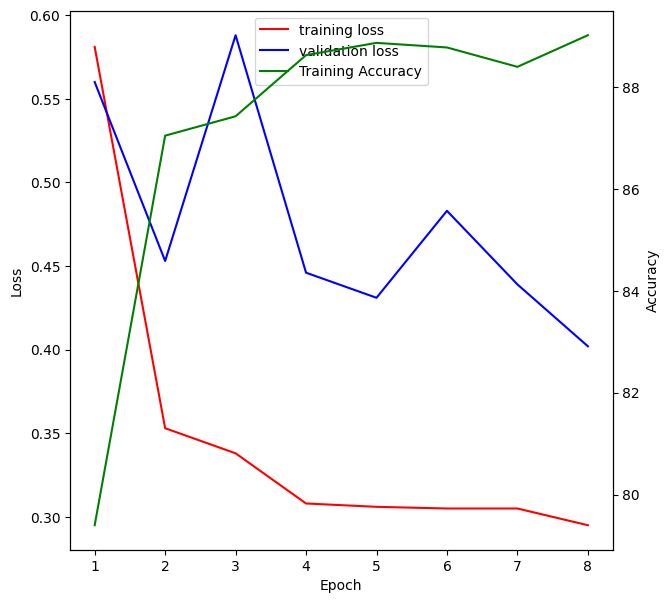

In [12]:
# initiation
model = ensemble_model.MyEnsembleModel(resnet, inception)
# modelling_config.model_prep_and_summary(model, device)
criterion = modelling_config.default_loss()
optimizer = modelling_config.default_optimizer(model=model)
num_epochs = 8

# get training results
trained_model, train_result_dict = cnn_model.train_model(model, device,
                                                         train_loader, val_loader, 
                                                         criterion, optimizer, num_epochs)
cnn_model.visualize_training(train_result_dict)


In [13]:
save_model_with_timestamp(trained_model, MODEL_SAVE_LOC)
save_csv_with_timestamp(train_result_dict, REPORT_SAVE_LOC)

Saved model to:  ..\data\04_model\20230112_004739_cnn_model.pt
Saved training report to:  ..\data\06_reporting\20230112_004739_training_report.csv


### 4. Testing

In [20]:
trained_model_list = os.listdir(MODEL_SAVE_LOC)
ENSEMBLE_MODEL_8_EPOCH_PATH = os.path.join(MODEL_SAVE_LOC, trained_model_list[-1])
ENSEMBLE_MODEL_8_EPOCH = ensemble_model.MyEnsembleModel(resnet, inception)
device = modelling_config.get_default_device()
print(ENSEMBLE_MODEL_8_EPOCH_PATH)
ENSEMBLE_MODEL_8_EPOCH.load_state_dict(torch.load(ENSEMBLE_MODEL_8_EPOCH_PATH))

..\data\04_model\20230112_004739_cnn_model.pt


<All keys matched successfully>

In [21]:
y_pred, y_true = cnn_model.infer(model = ENSEMBLE_MODEL_8_EPOCH, device = device, data_loader = test_loader)
confusion_matrix, class_metrics, overall_metrics = calculate_model_performance(y_pred, y_true, class_names = class_names)

In [22]:
print(confusion_matrix)
print(class_metrics)
print(overall_metrics)

tensor([[375.,   6.,   2.,   7.,   0.,  54.],
        [  1., 424.,   3.,   4.,   1.,   1.],
        [  2.,   4., 415.,  49.,   8.,   6.],
        [  7.,  15.,  91., 428.,  17.,  10.],
        [  8.,  13.,  41.,  32., 484.,   9.],
        [ 44.,  12.,   1.,   5.,   0., 421.]])
           accuracy  precision  recall  f1_score
buildings     0.956      0.845   0.858     0.851
forest        0.980      0.977   0.895     0.934
glacier       0.931      0.857   0.750     0.800
mountain      0.921      0.754   0.815     0.783
sea           0.957      0.825   0.949     0.882
street        0.953      0.872   0.840     0.856
             overall
accuracy       0.849
f1_mirco       0.849
f1_macro       0.851
f1_weighted    0.849
